In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df_surv = pd.read_csv("./Data/TBSM_SUD_BEING_RT_QU.csv")

df_flpop = pd.read_csv("./Data/TBSM_SUD_FLPOP_QU.csv")

df_income = pd.read_csv("./Data/TBSM_SUD_HOUSINCOM_QU.csv")

df_rent = pd.read_csv("./Data/TBSM_SUD_RENT_CURPRC_QU.csv")

df_repop = pd.read_csv("./Data/TBSM_SUD_REPOP_QU.csv")

df_sale= pd.read_csv("./Data/TBSM_SUD_SALE_MT_QU.csv")

df_sell = pd.read_csv("./Data/TBSM_SUD_SELNG_QU.csv")

df_store = pd.read_csv("./Data/TBSM_SUD_STOR_QU.csv")

df_surv_new = pd.read_csv("./Data/TBSM_SUD_SURV_RT_QU.csv")

df_worker = pd.read_csv("./Data/TBSM_SUD_WRC_POPLTN_QU.csv")

df_sk = pd.read_csv("./Data/sk_table.csv")

FileNotFoundError: [Errno 2] No such file or directory: './Data/sk_table.csv'

In [ ]:
df_surv_cafe = df_surv[df_surv['SVC_INDUTY_CD']=='CS100010']
df_sale_cafe = df_sale[df_sale['SVC_INDUTY_CD']=='CS100010']
df_sell_cafe = df_sell[df_sell['SVC_INDUTY_CD']=='CS100010'].drop(labels='SVC_INDUTY_CD', axis=1)
df_store_cafe = df_store[df_store['SVC_INDUTY_CD']=='CS100010'].drop(labels='SVC_INDUTY_CD', axis=1)
df_surv_new_cafe = df_surv_new[df_surv_new['SVC_INDUTY_CD']=='CS100010'].drop(labels='SVC_INDUTY_CD', axis=1)

df_surv_cafe = df_surv_cafe[['STDR_YYQU_CD','SUD_CD','YEAR_1_BEING_RT','YEAR_2_BEING_RT','YEAR_3_BEING_RT','YEAR_4_BEING_RT','YEAR_5_BEING_RT']]
df_sale_cafe = df_sale_cafe[['STDR_YYQU_CD','SUD_CD','SALE_MT_AVG','SALE_MT_AVG_90']]
df_sell_cafe = df_sell_cafe[['STDR_YYQU_CD','SUD_CD','THSMON_SELNG_AMT','THSMON_SELNG_CO']]
df_store_cafe = df_store_cafe[['STDR_YYQU_CD','SUD_CD','SIMILR_INDUTY_STOR_CO','OPBIZ_STOR_CO','CLSBIZ_STOR_CO']]
print(df_surv_cafe.shape)
print(df_sale_cafe.shape)

In [140]:
# df_cafe = pd.merge(df_cafe,df_surv_cafe,'outer')
df= []
df_cafe =  pd.merge(df_surv_cafe, df_sale_cafe,'outer',on=['STDR_YYQU_CD','SUD_CD'])
df_cafe =  pd.merge(df_cafe, df_sell_cafe,'outer',on=['STDR_YYQU_CD','SUD_CD'])
df_cafe =  pd.merge(df_cafe, df_store_cafe,'outer',on=['STDR_YYQU_CD','SUD_CD'])


# df_cafe =  pd.merge(df_cafe, df_surv_new_cafe,'inner',on=['STDR_YYQU_CD','SUD_CD'])
df_cafe= df_cafe.dropna(subset=['THSMON_SELNG_AMT','SIMILR_INDUTY_STOR_CO'])


In [141]:
df_cafe['STDR_YYQU_CD']=pd.to_datetime(df_cafe['STDR_YYQU_CD'].astype(str), format='%Y%m')

df_cafe['Year'] = df_cafe['STDR_YYQU_CD'].dt.year
df_cafe['Quarter'] = df_cafe['STDR_YYQU_CD'].dt.month

df_cafe = df_cafe.drop(labels='STDR_YYQU_CD', axis=1)


In [144]:
df_cafe.count()

SUD_CD                   6323
YEAR_1_BEING_RT          1704
YEAR_2_BEING_RT          1704
YEAR_3_BEING_RT          1704
YEAR_4_BEING_RT          1704
YEAR_5_BEING_RT          1704
SALE_MT_AVG              6323
SALE_MT_AVG_90           6323
THSMON_SELNG_AMT         6323
THSMON_SELNG_CO          6323
SIMILR_INDUTY_STOR_CO    6323
OPBIZ_STOR_CO            6323
CLSBIZ_STOR_CO           6323
Year                     6323
Quarter                  6323
dtype: int64

In [164]:
df_size = df_cafe.groupby(['SUD_CD']).size()
df_size

SUD_CD
1123000011     7
1123000029     9
1123000054     5
1123000057     7
1123000060     5
              ..
1129003813    19
1129003841    10
1129003906     8
1129003910     4
1129003914    11
Length: 456, dtype: int64

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score


# 'target' 열을 기준으로 데이터프레임 정렬
df_cafe.sort_values(by='SIMILR_INDUTY_STOR_CO', inplace=True)

# LSTM에 입력할 형태로 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_cafe['SIMILR_INDUTY_STOR_CO'].values.reshape(-1, 1))

training_data_len = int(np.ceil(len(scaled_data) * .95))

train_data = scaled_data[0:int(training_data_len), :]

# 데이터셋 생성
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# LSTM 모델 정의
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련
model.fit(x_train, y_train, batch_size=1, epochs=1)


2024-01-18 20:07:05.858951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-18 20:07:05.859464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-18 20:07:05.860305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5947/5947 [==============================] - 52s 9ms/step - loss: 3.9859e-05


In [158]:

# 테스트 데이터셋 생성
test_data = scaled_data[training_data_len - 60:, :]

x_test = []
y_test = df_cafe['SIMILR_INDUTY_STOR_CO'][training_data_len:].values

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 예측
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


r_squared = r2_score(y_test, predictions)
print(f'R-squared: {r_squared}')

# RMSE(평균 제곱근 오차) 계산
# rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
# print(f'RMSE: {rmse}')


2024-01-18 20:08:11.004212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-18 20:08:11.004760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-18 20:08:11.005549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 6ms/step
R-squared: 0.9374921487792198


/var/folders/3_/jn72t2z10bq8vm8vfx9c50b00000gn/T/ipykernel_45966/2732403649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


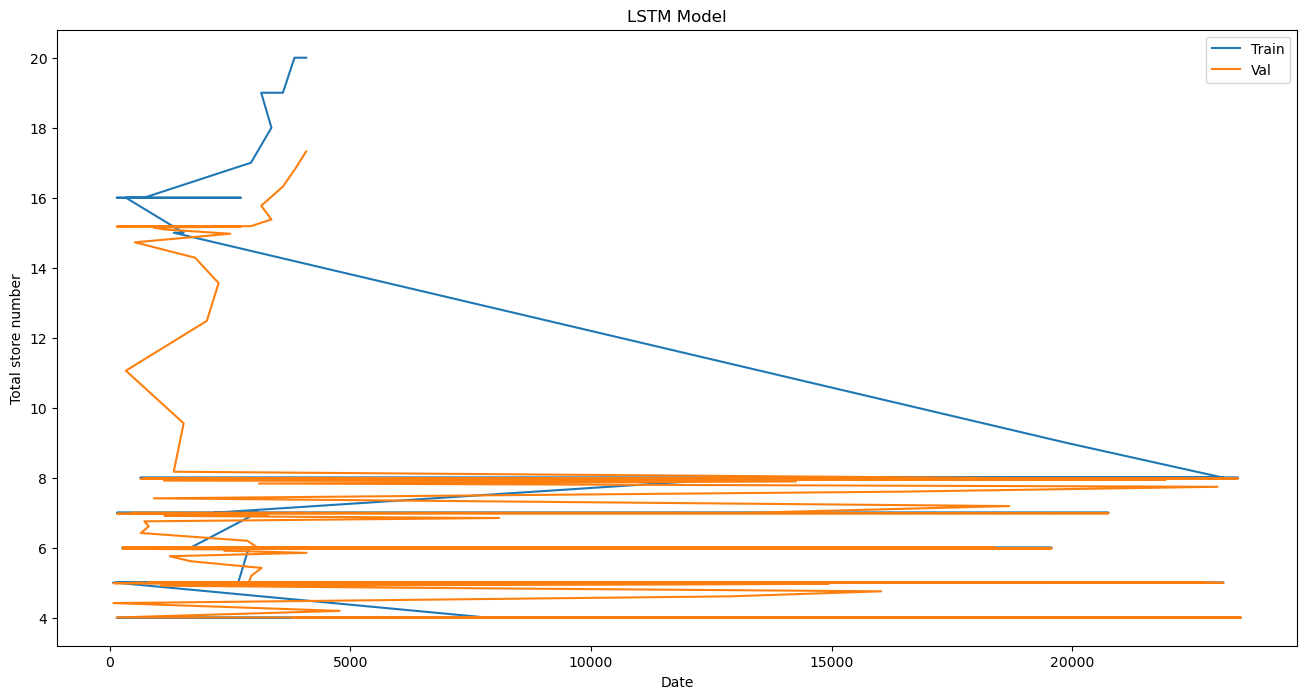

In [161]:

# 예측 결과 시각화
train = df_cafe[:training_data_len]
valid = df_cafe[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Total store number')
# plt.plot(train['SIMILR_INDUTY_STOR_CO'])
plt.plot(valid[['SIMILR_INDUTY_STOR_CO', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()


In [162]:
predictions

array([[ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.006755 ],
       [ 4.00

In [152]:
valid

[]